## Neural Style Transfer

We are going to use the VGG19 neural network to do the style transfer


In [ ]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.utils.image_utils import array_to_img
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import PIL

vgg = VGG19(include_top=False, weights='imagenet')
max_image_size = 1024

#Last conv layer because it contains most of the information about the content
content_layers = ['block5_conv2'] 

#Getting information about style, we will use these later 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
def tensor_to_image(tensor):
  tensor = np.array(tensor*255, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_image(path_to_img):
    img = tf.io.read_file(path_to_img)
    # Decode the image and convert it to a floating-point format-> Normalizing the image in the range of [0 , 1]
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize the image to the maximum size while maintaining its aspect ratio
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) #We remove the channels
    scale = max_image_size / max(shape)
    new_shape = tf.cast(scale*shape, tf.int32)
    return tf.image.resize(img, new_shape)


Text(0.5, 1.0, 'style image')

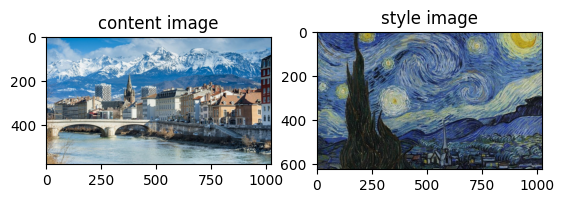

In [ ]:
content_image = load_image("./sample_data/grenoble.jpeg")
style_image = load_image("./sample_data/van_gogh.jpg")

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("content image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("style image")

In [ ]:
#The images will need to be in the tf.keras.models.Model which means we need to add a batch_size dimension in the begining 
style_image = style_image[tf.newaxis, :]
content_image = content_image[tf.newaxis, :]

In [ ]:
def get_style_extractor():
    style_output_tensors = [vgg.get_layer(layer).output for layer in style_layers]
    style_model = tf.keras.models.Model(inputs=vgg.input, outputs=style_output_tensors)
    return style_model

def get_content_extractor():
    content_output_tensors = [vgg.get_layer(layer).output for layer in content_layers]
    content_model = tf.keras.models.Model(inputs=vgg.input, outputs=content_output_tensors)
    return content_model

In [ ]:
style_extractor = get_style_extractor()
style_outputs = style_extractor(style_image * 255)

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


# def gram_matrix(style_features):
#     shape = style_features.shape[3]
#     style_features_flattened = np.reshape(style_features, (-1, shape))
#     gram_matrix = tf.transpose(style_features_flattened) @ style_features_flattened
#     input_shape = tf.shape(style_features)
#     num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
#     return gram_matrix / num_locations

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1
content_weight=1

In [ ]:
style_targets = style_extractor(preprocess_input(style_image*255))
style_targets = [gram_matrix(style_target) for style_target in style_targets]
content_extractor = get_content_extractor()
content_targets = content_extractor(preprocess_input(content_image*255))

In [ ]:
def style_loss(style_outputs):
  style_loss  = 0  
  for i in range(len(style_outputs)):
      mse_style = tf.reduce_mean((style_targets[i] - style_outputs[i])**2)
      style_loss += mse_style
  style_loss *= style_weight / len(style_layers)
  return style_loss

def content_loss(content_outputs):
  content_loss = 0
  for i in range(len(content_outputs)):
      mse_content = tf.reduce_mean((content_targets[i] - content_outputs[i])**2)
      content_loss += mse_content
  content_loss *= content_weight / len(content_layers)
  return content_loss




In [ ]:
@tf.function() # We compile as a graph so it is faster
def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs = style_extractor(preprocess_input(image * 255))
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_outputs = content_extractor(preprocess_input(image * 255))
        loss = style_loss(style_outputs) + content_loss(content_outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
        
        

Total time: 77.21962928771973


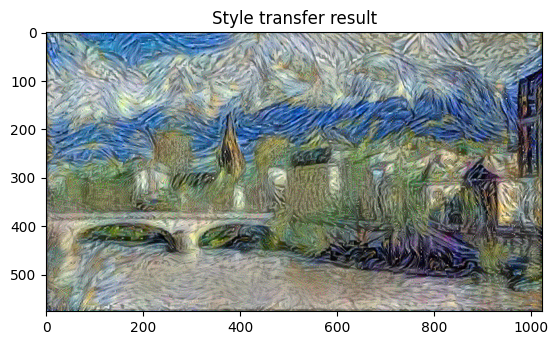

In [ ]:
start = time.time()
epochs = 2
steps_per_epoch = 100
for _ in range(epochs):
  for _ in range(steps_per_epoch):
    train_step(image)

plt.imshow(tensor_to_image(image))
plt.title("Style transfer result")

tensor_to_image(image).save("result.png")

end = time.time()
print("Total time: " + str(end-start))


In [ ]:
#Evaluating the metrics 

#Pass the new image through the models and recheck how good it matches the style and the content 
#Redo it on multiple paramaters: different optimizers and their parameters; different epochs; different networks


content_eval_outputs = content_extractor(preprocess_input(image * 255))
style_eval_outputs = style_extractor(preprocess_input(image * 255))
style_eval_outputs = [gram_matrix(style_eval_output) for style_eval_output in style_eval_outputs]

style_loss = style_loss(style_eval_outputs)
content_loss = content_loss(content_eval_outputs)

print(style_loss)
print(content_loss)




tf.Tensor(27203230.0, shape=(), dtype=float32)
tf.Tensor(2732.209, shape=(), dtype=float32)


In [ ]:
def resize_accurately(image1, image2):
  """Takes as input two images, makes them the same size accordingly"""
  if image1.shape[0] * image1.shape[1] < image2.shape[0] * image2.shape[1]:
    image1 = tf.image.resize(image1, [image2.shape[0], image2.shape[1]])
  else:
    image2 = tf.image.resize(image2, [image1.shape[0], image1.shape[1]])

  return image1, image2

In [ ]:
# Use SSIM to evaluate the model 

#---------------Content-------------------
# Determine which image is smaller and resize it to match the size of the larger image

resize_accurately(image, content_image)

ssim_content = tf.image.ssim(image, content_image, max_val=1.0).numpy()[0]

print('SSIM score for content:', ssim_content)

im1 , im2 = resize_accurately(image, style_image)

ssim_style = tf.image.ssim(im1, im2, max_val=1.0).numpy()[0]

print('SSIM score for content:', ssim_style)



SSIM score for content: 1.0


TypeError: ignored